In [2]:
import pandas as pd
import json
import os
from tqdm import tqdm

def parse_gemini_response(response_text):
    json_str = response_text.split('```json\n')[1].split('\n```')[0]
    info = json.loads(json_str)
    return info

# Question generation prompt
with open("prompts/impact_extraction_v2.txt", "r") as f:
    impact_prompt_template = f.read()

# Save all claims and search results
save_folder = "data"

df = pd.read_csv('data/fnd_politifact_claims_final.csv')
df.columns, len(df)

(Index(['claim', 'claim_factcheck_url', 'claim_author', 'claim_source',
        'claim_date', 'fact_check_date', 'justification',
        'fact_checking_sources', 'issue', 'label'],
       dtype='object'),
 2684)

In [3]:
from utils.gemini_interface_parallel import batch_process

secrets_file = "secrets/gemini_keys_new.json"
model_name = "gemini-2.0-flash-exp"
# model_name = "gemini-1.5-flash-latest"
temperature = 0.25
top_p = 0.95

# Generate impact score for all claims
claim_iscores_filename = f"{save_folder}/claim_impact_scores.json"
try:    
    with open(claim_iscores_filename, "r", encoding="utf-8") as fp:
        claim_iscores = json.load(fp)
except FileNotFoundError:
    claim_iscores = {}

print(f"{len(claim_iscores)} claims already processed")

1999 claims already processed


/Users/abz/mambaforge/envs/thesis/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
prompts = []
for index, row in tqdm(df.iterrows(), total=len(df)):
    if index == 2000:
        break

    claim = row["claim"]
    if claim in claim_iscores:
        continue
    
    claim_author = row["claim_author"].strip() if "claim_author" in row and pd.notna(row["claim_author"]) and row["claim_author"] is not None else "UNKNOWN"
    claim_source = row["claim_source"].strip() if "claim_source" in row and pd.notna(row["claim_source"]) and row["claim_source"] is not None else "UNKNOWN"
    claim_date = row["claim_date"].strip() if "claim_date" in row and pd.notna(row["claim_date"]) and row["claim_date"] is not None else "UNKNOWN"
    # Generate questions using Gemini API
    prompt = impact_prompt_template.replace("[Insert Claim Here]", claim)\
        .replace("[Insert Source Here]", claim_source)\
        .replace("[Insert Author Here]", claim_author)\
        .replace("[Insert Date Here]", claim_date)
    
    prompts.append(
                    ("chat", 
                     prompt,
                     claim
                    )
                )
    
print("Total prompts:", len(prompts))
    
responses = batch_process(prompts, secrets_file, model_name, temperature, top_p)

failed_row_ids = []
for response in responses:
    claim = response[1]
    if response[0] is None:
        failed_row_ids.append(claim)
        continue

    try:    
        claim_iscores[claim] = parse_gemini_response(response[0].text)
    except:
        print("Failed to parse response for claim:", claim)
        print(response)
        continue


print("Total failed claims:", len(failed_row_ids))

# Save claim_iscores after each claim
with open(claim_iscores_filename, "w", encoding="utf-8") as fp:
    json.dump(claim_iscores, fp, indent=4)

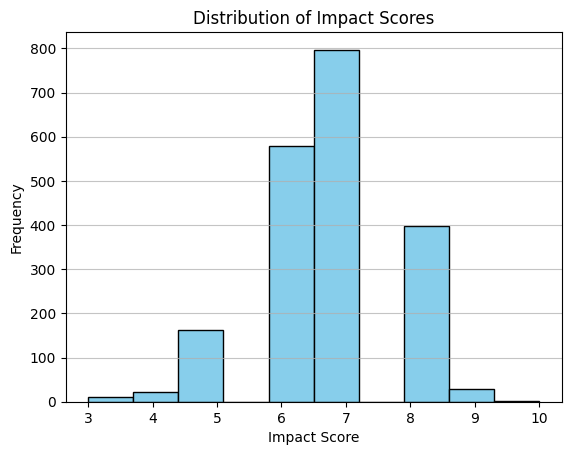

In [4]:
# Build a graph of the histogram of the impact scores
import matplotlib.pyplot as plt

plt.hist([obj["Impact Score"] for obj in claim_iscores.values()], bins=10, color='skyblue', edgecolor='black')
plt.grid(axis='y', alpha=0.75)
plt.title('Distribution of Impact Scores')
plt.xlabel('Impact Score')
plt.ylabel('Frequency')
plt.show()

In [5]:
scores_map = {}
for claim, obj in claim_iscores.items():
    if obj["Impact Score"] not in scores_map:
        scores_map[obj["Impact Score"]] = [(claim, obj["Justification"])]
    else:
        scores_map[obj["Impact Score"]].append((claim, obj["Justification"]))

In [12]:
import random

test_score = 9

if test_score in scores_map:
    scores_obj = scores_map[test_score]
    claim_tuple = random.choice(scores_obj)
    print("Claim:", claim_tuple[0])
    print("Justification:", '\n'.join(claim_tuple[1].split(".")))
else:
    print("No claims found for score:", test_score)

Claim: Chinese scientists “created (a) new COVID-19 strain (with) 100% fatality.”
Justification: The claim is highly sensational and alarming, suggesting a deliberately created, extremely lethal virus
 The source being an Instagram post means it has the potential to reach a wide audience, especially if shared widely
 The claim is likely false, but the potential for panic, fear, and distrust is very high
 It could also incite xenophobia and international tensions
 The combination of a sensational claim, potential for wide reach, and potential for harm warrants a very high impact score

